Classification of the bacteria data using three different classifiers:
1. SVM
2. RandomForest with decision stumps
3. AdaBoost with decision stumps.

The data is each replicate of each species along the rows, and the fluorescense spectra readings at the lag growth phase along the columns. 

A synthetic training dataset is created while the model is tested on the original dataset. The synthesised dataset is created from the original dataset by sampling with replacement from each class and adding some gaussian noise. This is done such that each class is equally represented in the training dataset, and that no exact copies of the original data points appear in the training dataset.

In [1]:
import os

import numpy as np
import pandas as pd

In [2]:
os.getcwd()

'/home/anthony/summer-bursary-2018/bacteria'

In [3]:
os.listdir('data')

['Classific.py',
 'graphs.pdf',
 'growth_stages.csv',
 '16ms_32ms_growth_phase_spectra.csv',
 'PC6allwavelengths.png',
 'wavelengths.csv',
 '16_ms_lag_codes.csv',
 'bacteria.csv']

In [4]:
df = pd.read_csv('data/bacteria.csv', header=[0, 1, 2], index_col=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1043 entries, 0 to 1042
Columns: 135 entries, (lag, bc, 01) to (stat, se, 07)
dtypes: float64(135)
memory usage: 1.1 MB


# Preprocessing

In [5]:
lag = df['lag'].T
lag = lag.add_prefix('lag_')
lag.head()

lag_0     lag_1     lag_2     lag_3     lag_4     lag_5  \
species replicate                                                               
bc      01         0.000000  1.560060  0.715025 -0.520060  0.130014 -2.080180   
        02         0.622353 -2.115990  0.062234  2.178335  1.867163  1.120305   
        03         0.064528  0.645279 -1.032450 -2.064991 -1.419711  1.032515   
        04        -1.094650 -2.554170 -0.912210  0.851433  3.709871  1.520432   
        05        -1.492810 -0.559800  2.923387  3.047967  2.985793  2.985763   

                          lag_6     lag_7     lag_8     lag_9    ...     \
species replicate                                                ...      
bc      01         0.000000e+00  1.040112  1.235136 -0.195020    ...      
        02         8.713430e-01 -1.369260 -1.929420  0.684622    ...      
        03        -2.000491e+00 -0.903453  2.968462  1.032499    ...      
        04         8.514440e-01 -2.067810 -1.581270  0.304085    ...      
        05        -3.590000e-07 -0.995270 -0.933060 -1.990480    ...      

                   lag_1033  lag_1034  lag_1035  lag_1036  lag_1037  lag_1038  \
species replicate                                                               
bc      01         1.170374  2.730861  3.835922  1.755222  1.235332  4.355984   
        02        -0.373450 -0.187040 -2.302970  0.124451  0.809098  1.058059   
        03         3.097847  4.775991  4.775919  4.259427  2.129823  0.064477   
        04         4.257782  3.284733  0.851676  2.493739  3.467134  5.900169   
        05         4.479034  2.488391  3.546049  1.057399  3.981489  6.469838   

                   lag_1039  lag_1040  lag_1041  lag_1042  
species replicate                                          
bc      01         0.520024  0.715032 -0.325010 -0.520030  
        02         2.676111  0.622357  0.560118 -0.435650  
        03        -2.516599  0.516229 -0.903391  1.096991  
        04         1.520354  2.067671  0.121629  1.094670  
        05        -0.933000  0.062199 -0.435400  1.430629  

[5 rows x 1043 columns]

In [6]:
X = lag.values
X = (X - X.min()) / (X.max() - X.min())

print(X.min(), X.max(), X.mean(), X.std())

0.0 1.0 0.10412849167759197 0.1759401930906604


In [7]:
y = lag.reset_index()['species']
y = y.values
print(y[0:5])

['bc' 'bc' 'bc' 'bc' 'bc']


In [8]:
from sklearn.utils import shuffle

X, y = shuffle(X, y)

print(X[:5])
print(y[:5])

[[0.00439115 0.00453494 0.00462343 ... 0.00454601 0.00439115 0.00462343]
 [0.00433107 0.00457004 0.00429693 ... 0.00431969 0.00450176 0.004479  ]
 [0.00432043 0.00449043 0.00459243 ... 0.00460376 0.00458109 0.00486442]
 [0.00444556 0.00443432 0.00426571 ... 0.00462541 0.00424323 0.004513  ]
 [0.0045279  0.00441028 0.00489382 ... 0.00468473 0.00450176 0.004737  ]]
['ec' 'sa' 'bc' 'sa' 'sa']


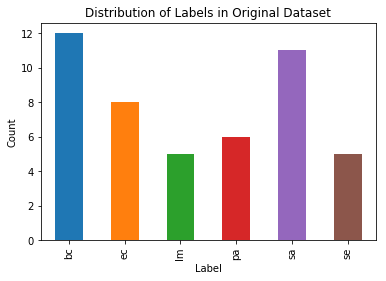

In [9]:
%matplotlib inline

ax = pd.Series(y).value_counts().sort_index().plot(kind='bar')
ax.set(xlabel='Label',
      ylabel='Count',
      title='Distribution of Labels in Original Dataset');

(42, 1043) (42,)


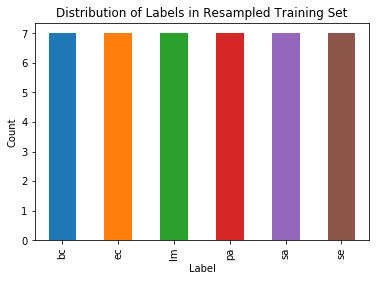

In [10]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

RANDOM_STATE = 42

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.4, random_state=RANDOM_STATE)

smote = SMOTE(sampling_strategy='auto', random_state=RANDOM_STATE, k_neighbors=2)
X_train, y_train = smote.fit_resample(X_train, y_train)

print(X_train.shape, y_train.shape)

ax = pd.Series(y_train).value_counts().sort_index().plot(kind='bar')
ax.set(xlabel='Label',
      ylabel='Count',
      title='Distribution of Labels in Resampled Training Set');

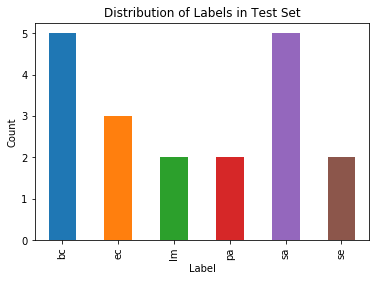

In [11]:
ax = pd.Series(y_test).value_counts().sort_index().plot(kind='bar')
ax.set(xlabel='Label',
      ylabel='Count',
      title='Distribution of Labels in Test Set');

# PCA + SVM

In [12]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.99, svd_solver='full')
pca.fit(X_train)

X_pca = pca.transform(X_train)

print(X_pca.shape)

(42, 2)


In [13]:
from sklearn.svm import SVC
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold, cross_val_score, GridSearchCV

param_grid = {
    'kernel': ['linear', 'rbf'],
    'gamma': [10 ** -n for n in range(10)],
    'C': [10 ** n for n in range(-9, 2)]
}

cv = StratifiedKFold(n_splits=3)
clf = SVC()

grid_search = GridSearchCV(clf, param_grid, cv=cv, verbose=10, n_jobs=4)
grid_search.fit(X_pca, y_train)

print(grid_search.best_score_)
print(grid_search.best_params_)

Fitting 3 folds for each of 220 candidates, totalling 660 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Batch computation too fast (0.1854s.) Setting batch_size=2.
[Parallel(n_jobs=4)]: Done  18 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Batch computation too fast (0.0231s.) Setting batch_size=34.
[Parallel(n_jobs=4)]: Done  30 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Batch computation too fast (0.1066s.) Setting batch_size=126.


0.5952380952380952
{'C': 10, 'gamma': 1, 'kernel': 'rbf'}


[Parallel(n_jobs=4)]: Done 660 out of 660 | elapsed:    1.3s finished
/home/anthony/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [14]:
%%time

cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=20)
scores = cross_val_score(grid_search.best_estimator_, X_pca, y_train, cv=cv)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.51 (+/- 0.19)
CPU times: user 114 ms, sys: 3.95 ms, total: 118 ms
Wall time: 118 ms


In [15]:
%%time

cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=20)
scores = cross_val_score(grid_search.best_estimator_, X_train, y_train, cv=cv)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.55 (+/- 0.26)
CPU times: user 261 ms, sys: 429 µs, total: 261 ms
Wall time: 261 ms


# Random Forest with Decision Stumps

In [16]:
%%time

from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=1024, max_depth=1, random_state=RANDOM_STATE)
cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=20)
scores = cross_val_score(clf, X_pca, y_train, cv=cv)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.47 (+/- 0.19)
CPU times: user 46.9 s, sys: 55.4 ms, total: 47 s
Wall time: 47 s


In [17]:
%%time

clf = RandomForestClassifier(n_estimators=1024, max_depth=1, random_state=RANDOM_STATE)
cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=20)
scores = cross_val_score(clf, X_train, y_train, cv=cv)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.66 (+/- 0.26)
CPU times: user 50.6 s, sys: 32.1 ms, total: 50.6 s
Wall time: 50.6 s


# AdaBoost

In [18]:
%%time

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),
                        n_estimators=1024)
cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=20)
scores = cross_val_score(clf, X_pca, y_train, cv=cv)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.33 (+/- 0.17)
CPU times: user 1min 5s, sys: 88 ms, total: 1min 5s
Wall time: 1min 5s


In [19]:
%%time

clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),
                        n_estimators=1024)
cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=20)
scores = cross_val_score(clf, X_train, y_train, cv=cv)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.38 (+/- 0.20)
CPU times: user 3min 24s, sys: 172 ms, total: 3min 25s
Wall time: 3min 25s


# Validation

              precision    recall  f1-score   support

          bc       0.67      0.40      0.50         5
          ec       0.00      0.00      0.00         3
          lm       0.50      1.00      0.67         2
          pa       0.00      0.00      0.00         2
          sa       1.00      0.80      0.89         5
          se       0.00      0.00      0.00         2

   micro avg       0.42      0.42      0.42        19
   macro avg       0.36      0.37      0.34        19
weighted avg       0.49      0.42      0.44        19



/home/anthony/miniconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/anthony/miniconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/anthony/miniconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


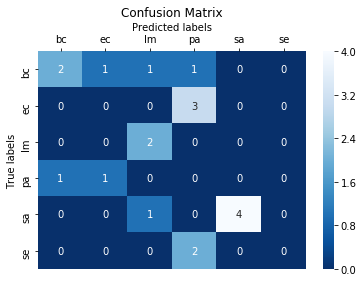

In [20]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

y_pred = grid_search.best_estimator_.predict(pca.transform(X_test))

print(classification_report(y_test, y_pred))

labels = lag.index.levels[0]
cm = confusion_matrix(y_test, y_pred, labels)    

ax = sns.heatmap(cm, annot=True, cmap='Blues_r')
ax.set(xlabel='Predicted labels', 
       ylabel='True labels',
       title='Confusion Matrix')
ax.xaxis.set_ticklabels(labels)
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top') 
ax.yaxis.set_ticklabels(labels);